#### 数据集：Zachary‘s karate club network
图只有1个

每一个点有34维度特征

对每一个点做4分类


In [1]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}')
print('================================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub()
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [2]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


34x34====>M*F

M为样本个数，F为特征维度

一共有156的点，从source到target映射

y为标签

train_mask主要用于计算损失，能够标记有标签的点

In [3]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

前一个为0~34号点，后一位为该点与哪些点有关系

index稀疏表示的，并不是一个n*n的邻接矩阵

#### 可视化部分

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# 绘制graph
def visualize_graphs(g, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(g, pos=nx.spring_layout(g, seed=42), with_labels=G.nodes, node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], c=color, s=140, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch:{epoch}, loss:{loss.item():.4f}', fontsize=16)
    plt.show()

#### 使用networkx可视化展示

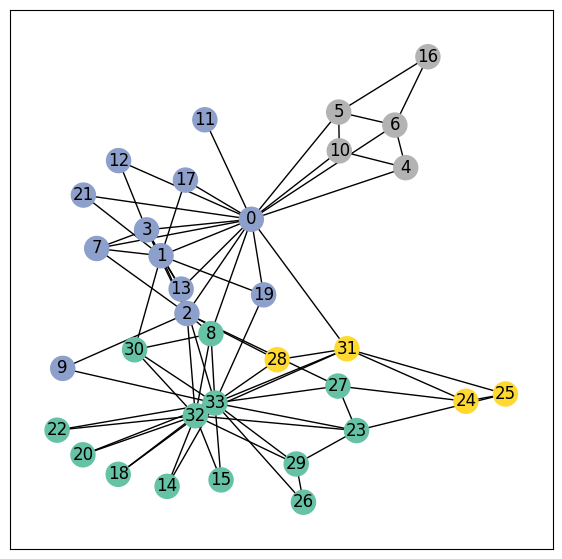

In [19]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graphs(G, color=data.y)


#### GCN网络定义

In [20]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        # 输入34个特征输出4个分类
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        # 最终产生中间结果：2维向量
        self.conv3 = GCNConv(4, 2)
        # 将2维向量进行4分类任务
        self.classifier = Linear(2, dataset.num_classes)    # 4

    # 前向传播
    def forward(self, x, edge_index):
        # 输入特征x与邻接矩阵edge_index
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)

        # 分类层
        out = self.classifier(h)
        return out,h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### 输出特征展示

模型还没有训练，用随机画，观察最后输出的二位特征是什么样子

Embedding shape: [34, 2]


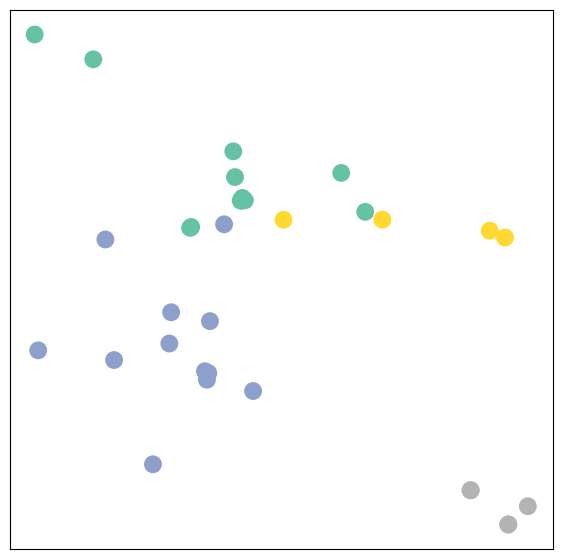

In [32]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

### 训练模型：semi-supervised

  0%|          | 0/401 [00:00<?, ?it/s]

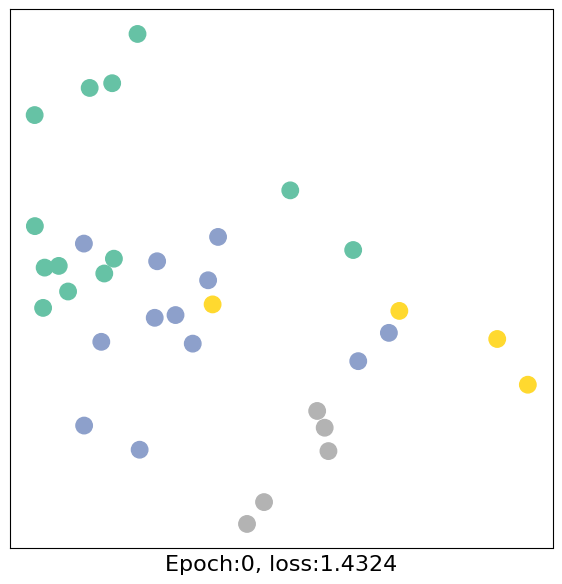

  0%|          | 1/401 [00:00<02:35,  2.57it/s]

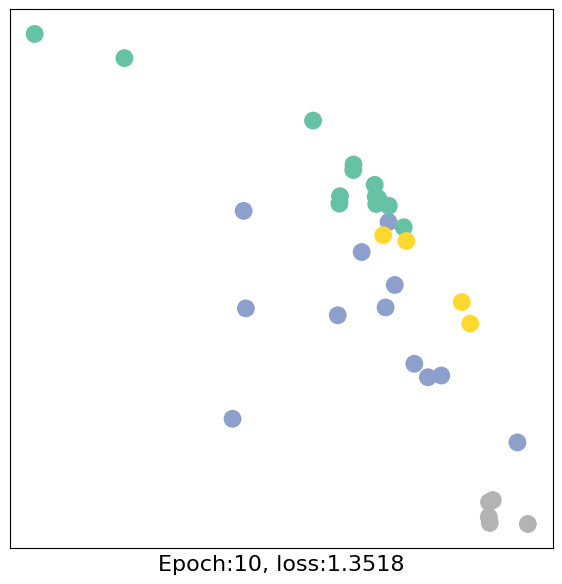

  3%|▎         | 11/401 [00:00<00:25, 15.34it/s]

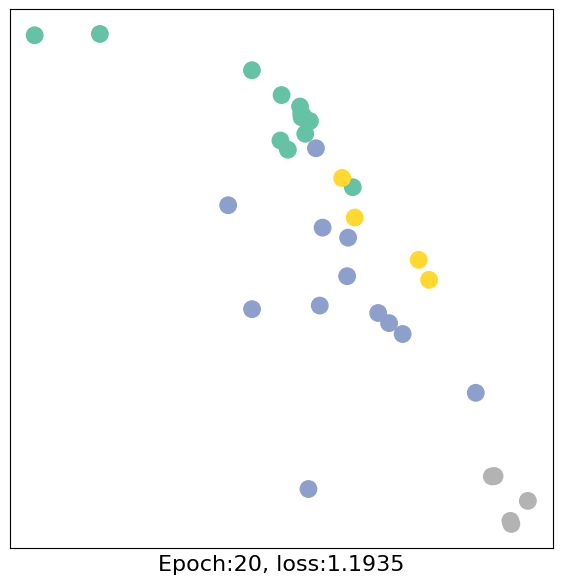

  5%|▌         | 21/401 [00:01<00:19, 19.12it/s]

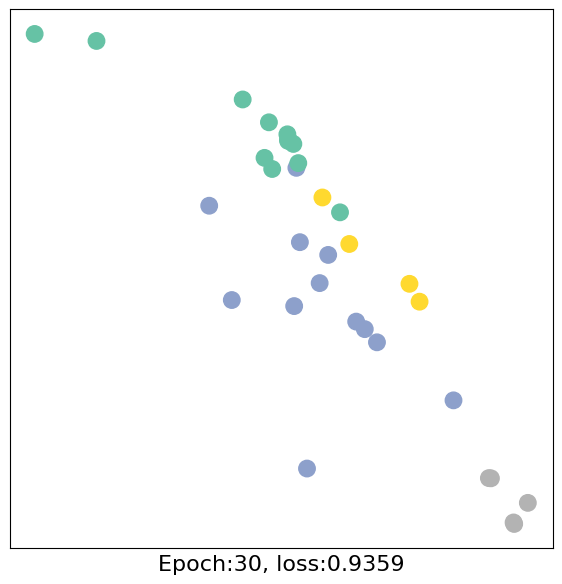

  8%|▊         | 31/401 [00:01<00:17, 20.58it/s]

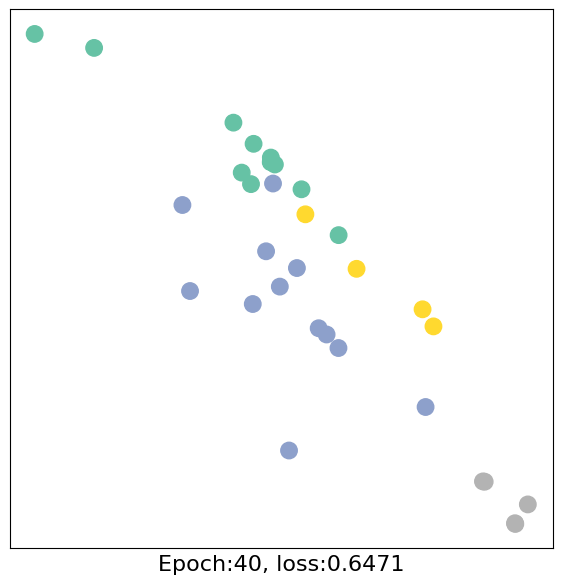

 10%|█         | 41/401 [00:02<00:16, 21.68it/s]

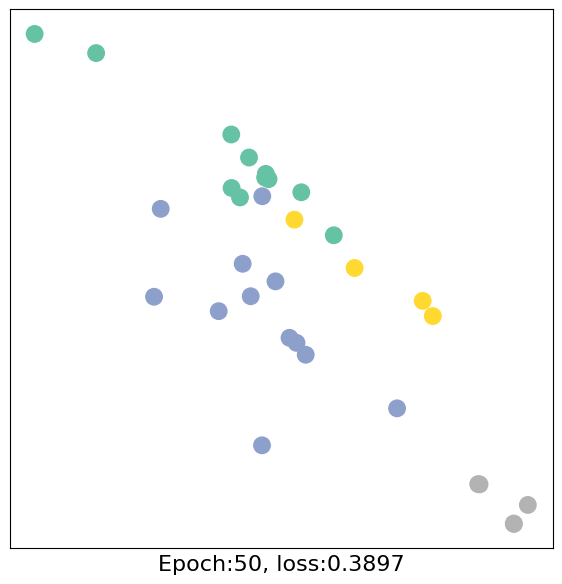

 13%|█▎        | 51/401 [00:02<00:15, 22.27it/s]

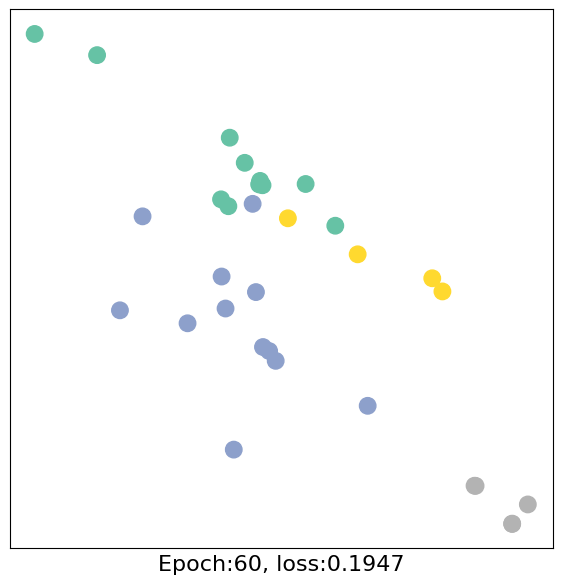

 15%|█▌        | 61/401 [00:02<00:14, 22.72it/s]

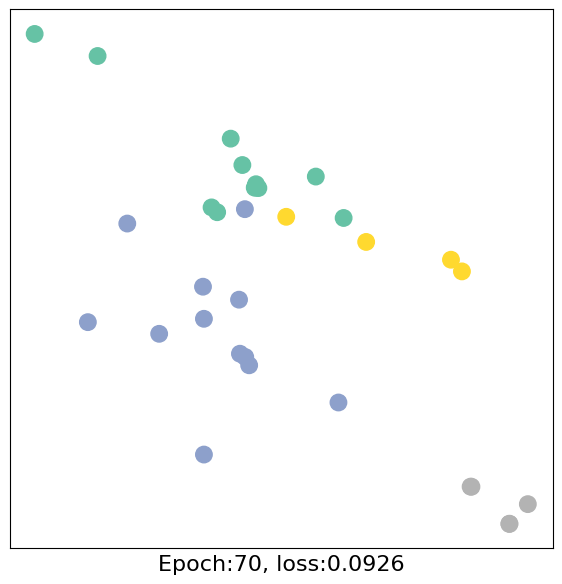

 18%|█▊        | 71/401 [00:03<00:14, 22.96it/s]

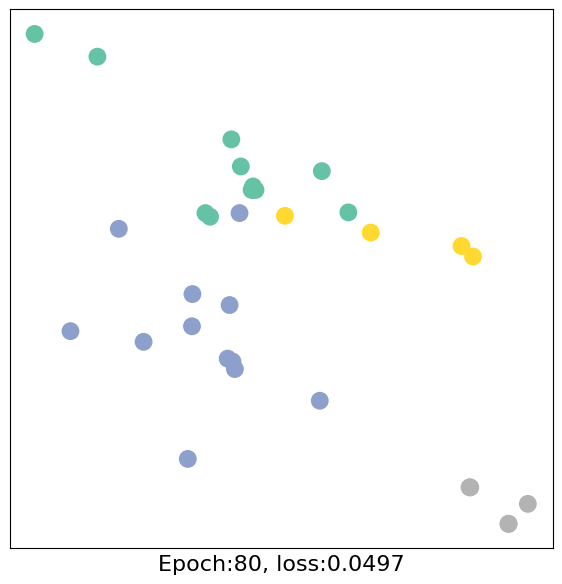

 20%|██        | 81/401 [00:03<00:13, 23.10it/s]

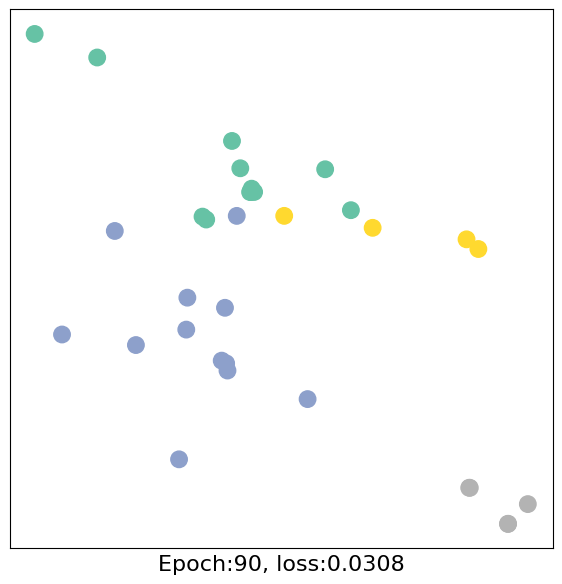

 23%|██▎       | 91/401 [00:04<00:13, 22.98it/s]

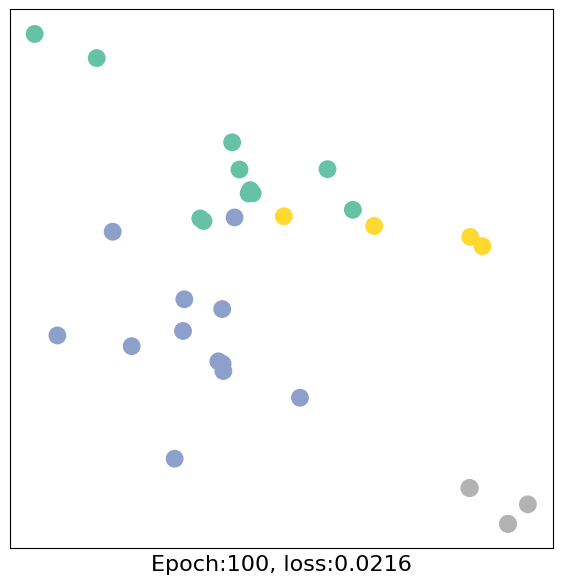

 25%|██▌       | 101/401 [00:04<00:13, 22.89it/s]

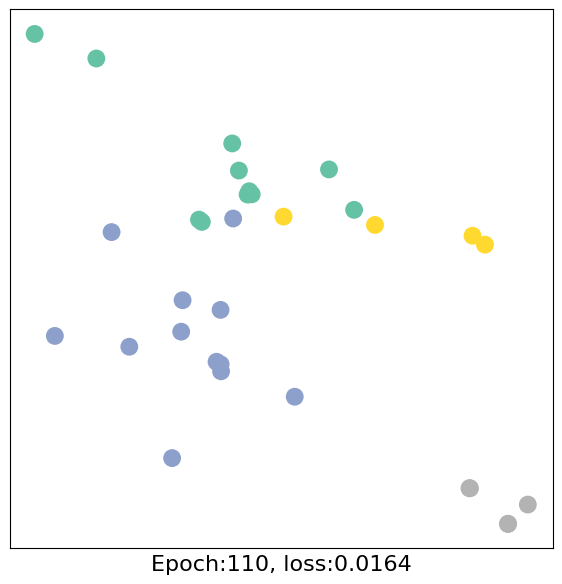

 28%|██▊       | 111/401 [00:05<00:12, 23.07it/s]

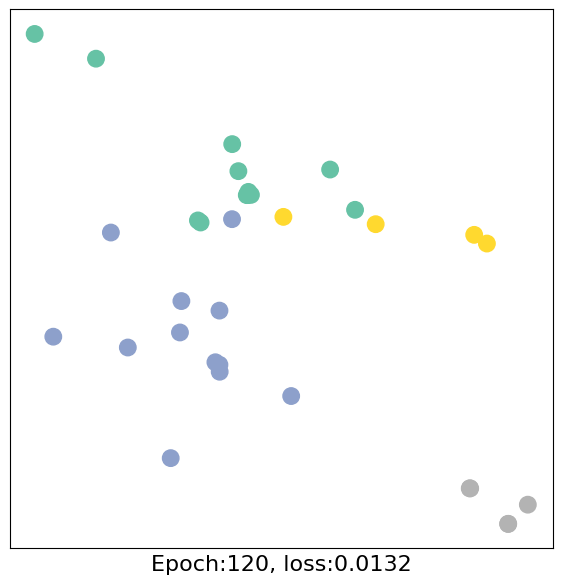

 30%|███       | 121/401 [00:05<00:12, 23.20it/s]

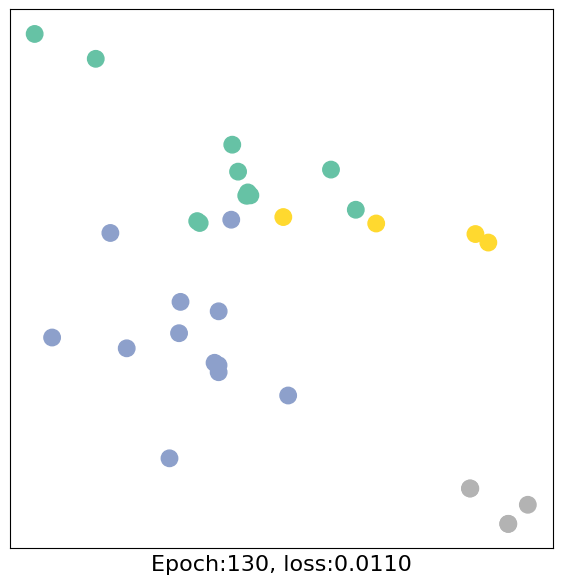

 33%|███▎      | 131/401 [00:05<00:11, 23.32it/s]

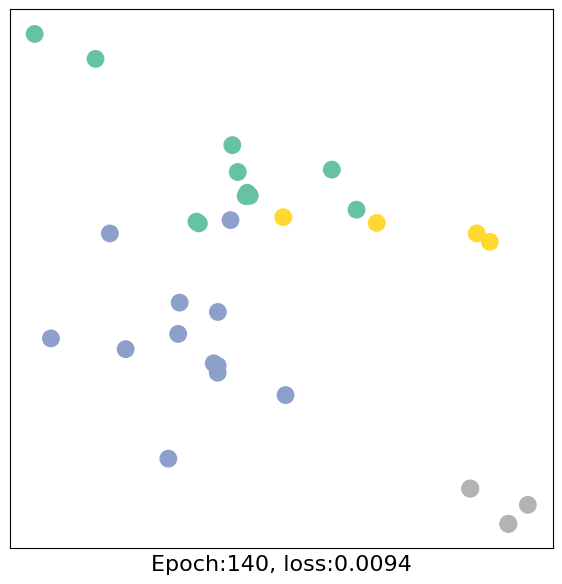

 35%|███▌      | 141/401 [00:06<00:11, 23.41it/s]

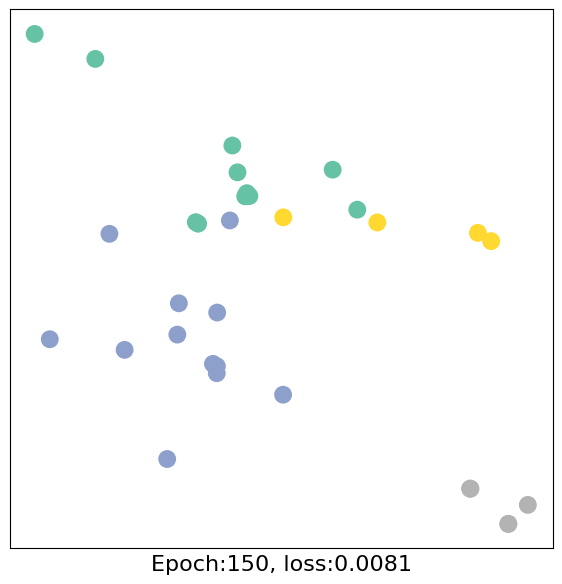

 38%|███▊      | 151/401 [00:06<00:10, 23.47it/s]

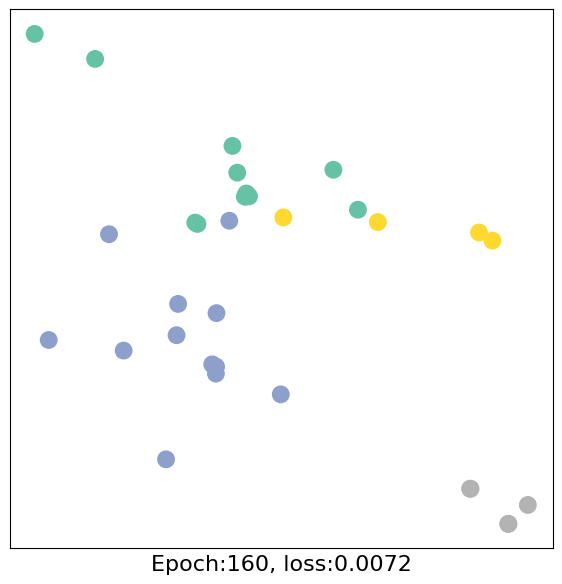

 40%|████      | 161/401 [00:07<00:10, 23.52it/s]

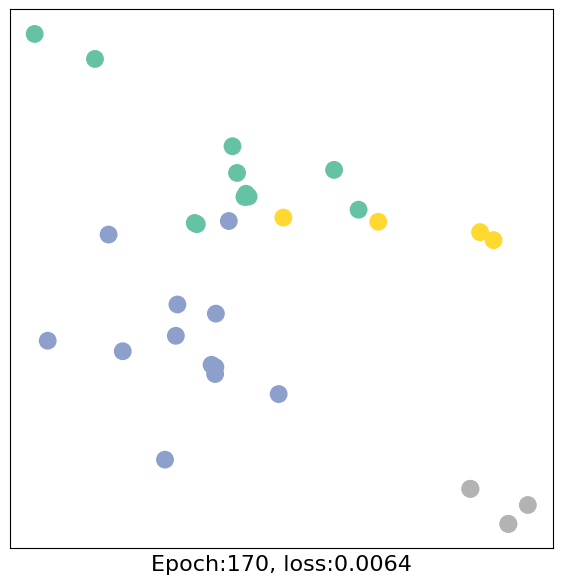

 43%|████▎     | 171/401 [00:07<00:09, 23.57it/s]

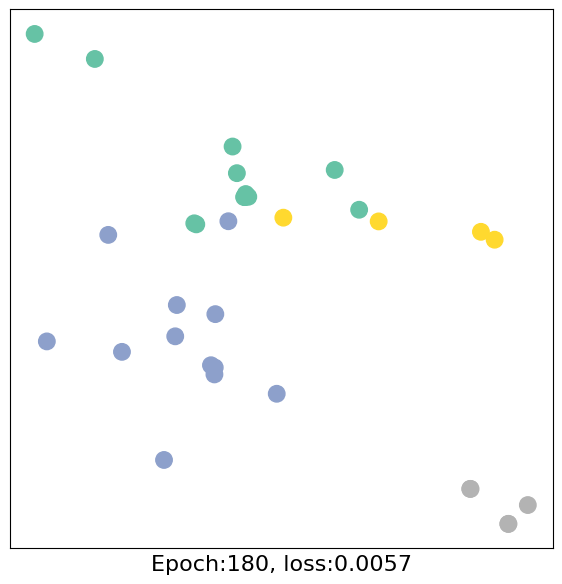

 45%|████▌     | 181/401 [00:08<00:09, 23.59it/s]

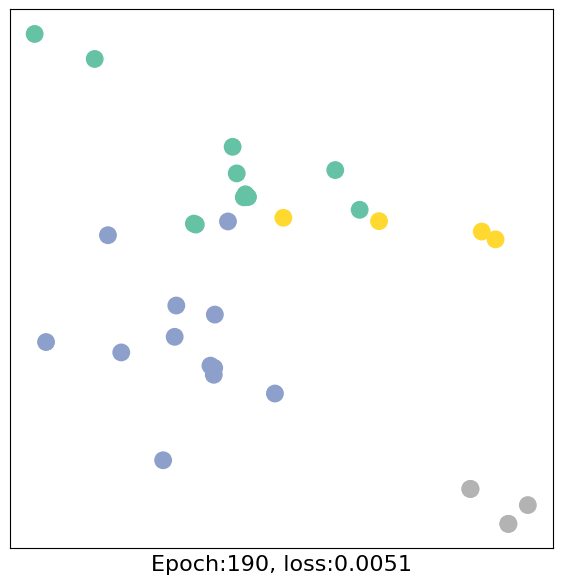

 48%|████▊     | 191/401 [00:08<00:08, 23.59it/s]

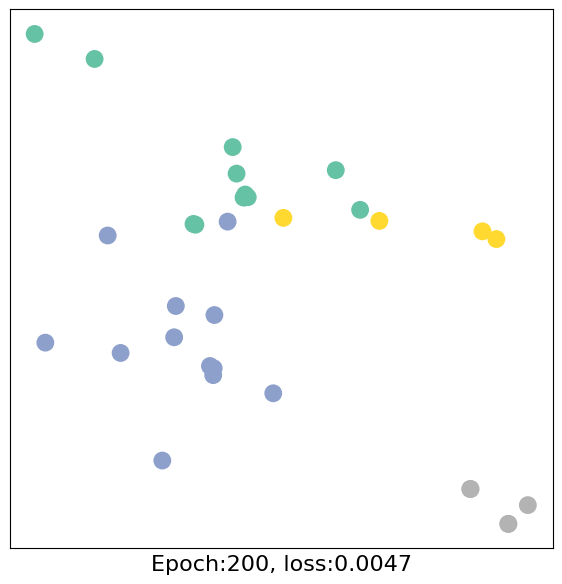

 50%|█████     | 201/401 [00:08<00:08, 23.64it/s]

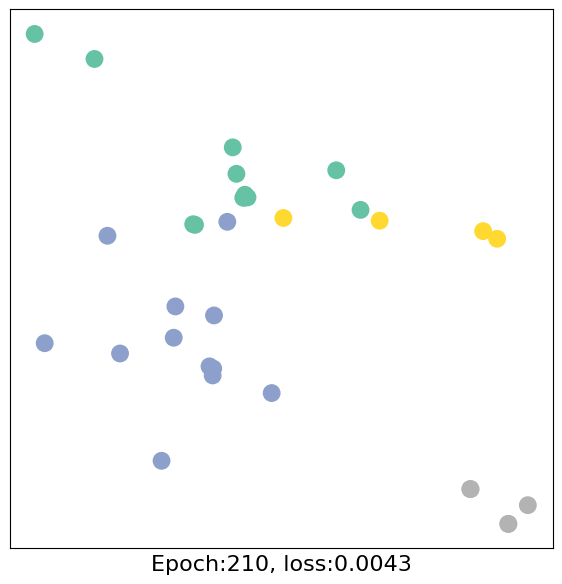

 53%|█████▎    | 211/401 [00:09<00:08, 23.60it/s]

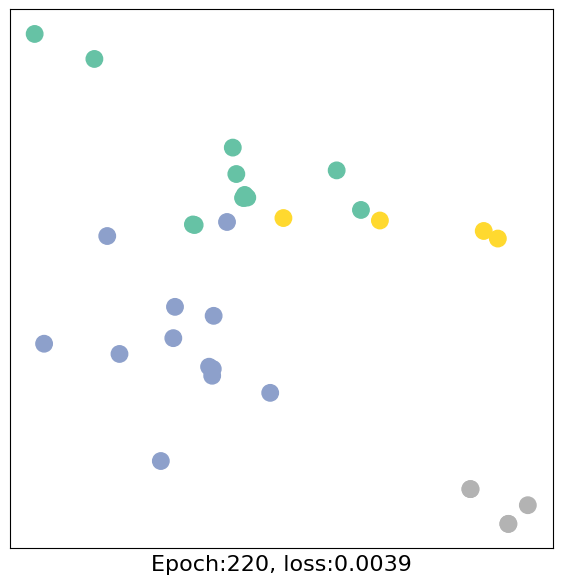

 55%|█████▌    | 221/401 [00:09<00:07, 23.56it/s]

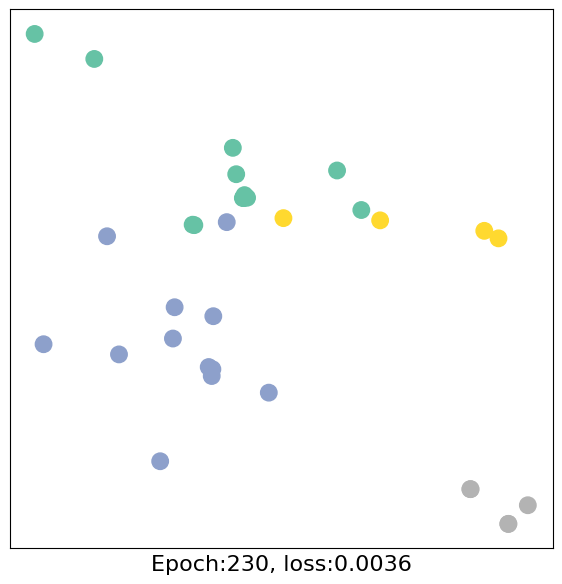

 58%|█████▊    | 231/401 [00:10<00:07, 23.39it/s]

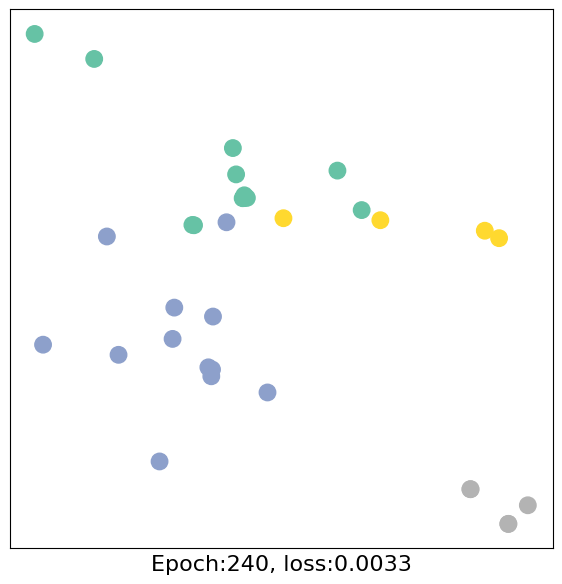

 60%|██████    | 241/401 [00:10<00:06, 23.44it/s]

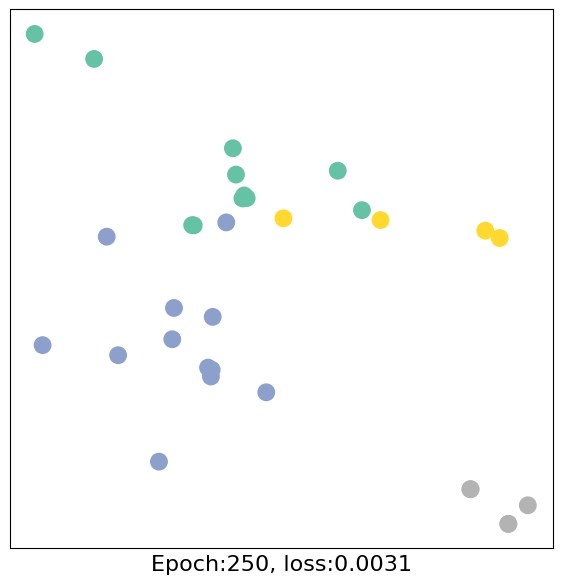

 63%|██████▎   | 251/401 [00:11<00:06, 23.48it/s]

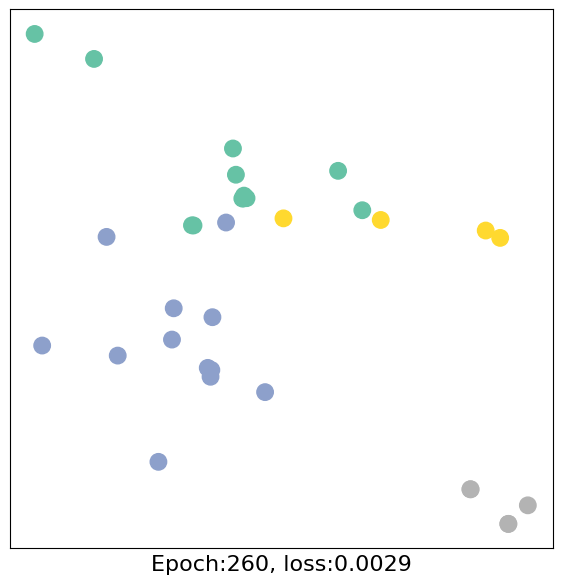

 65%|██████▌   | 261/401 [00:11<00:05, 23.54it/s]

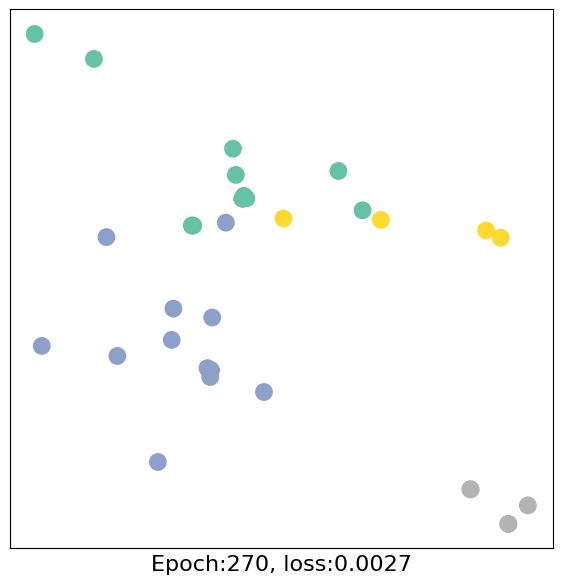

 68%|██████▊   | 271/401 [00:11<00:05, 23.39it/s]

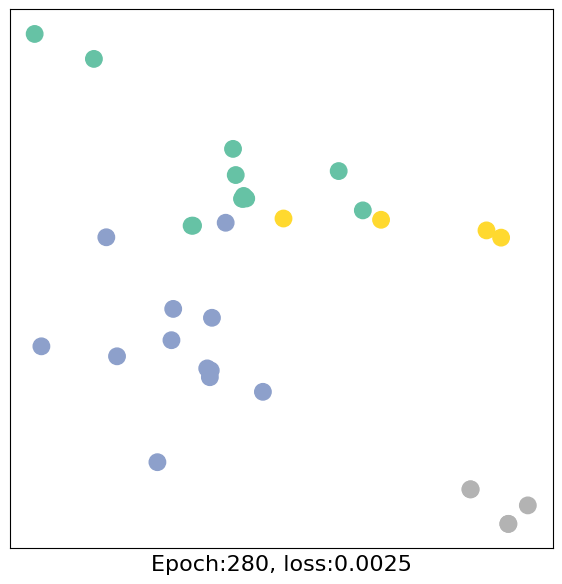

 70%|███████   | 281/401 [00:12<00:05, 23.51it/s]

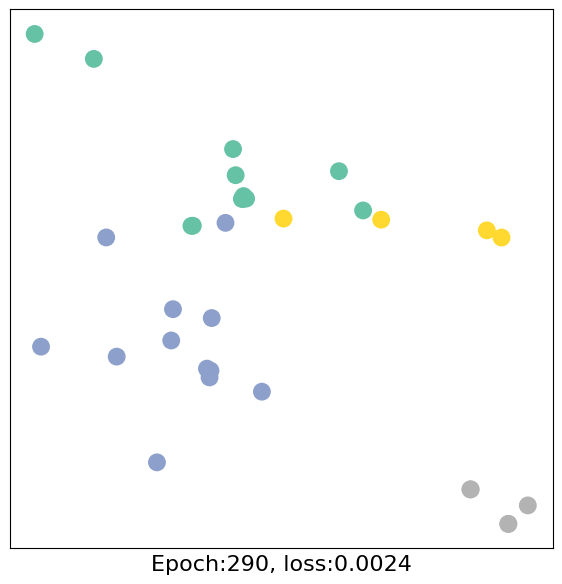

 73%|███████▎  | 291/401 [00:12<00:04, 23.57it/s]

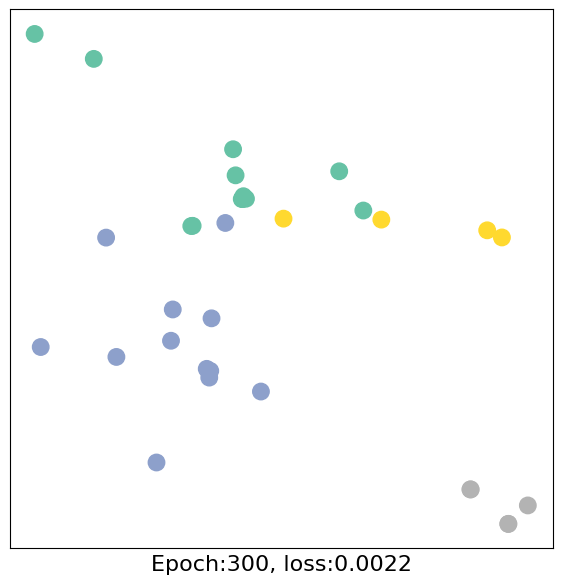

 75%|███████▌  | 301/401 [00:13<00:04, 23.59it/s]

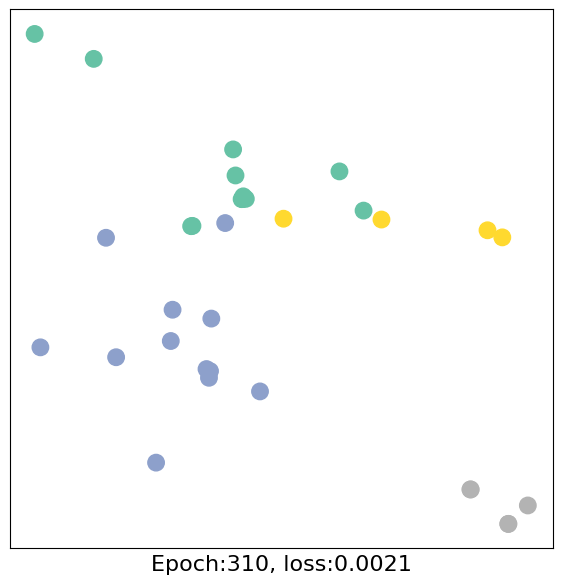

 78%|███████▊  | 311/401 [00:13<00:03, 23.57it/s]

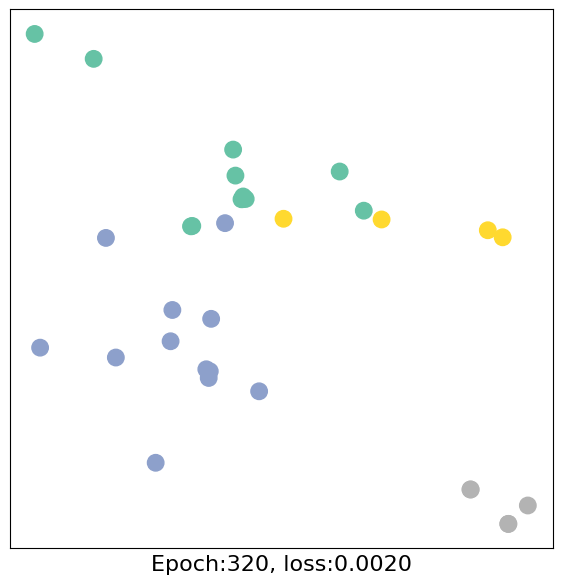

 80%|████████  | 321/401 [00:14<00:03, 23.60it/s]

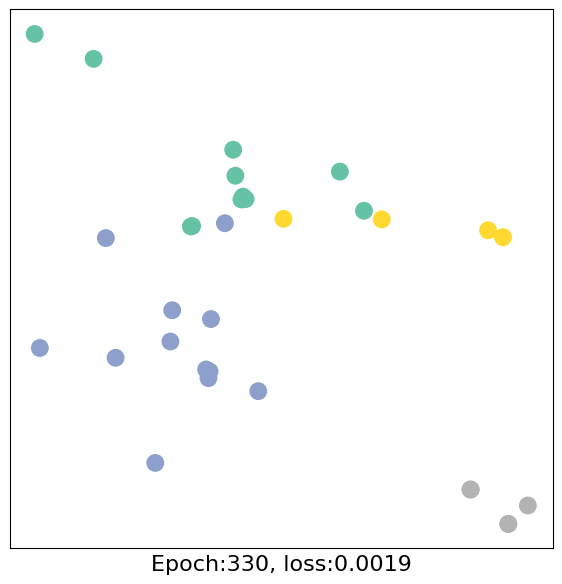

 83%|████████▎ | 331/401 [00:14<00:02, 23.55it/s]

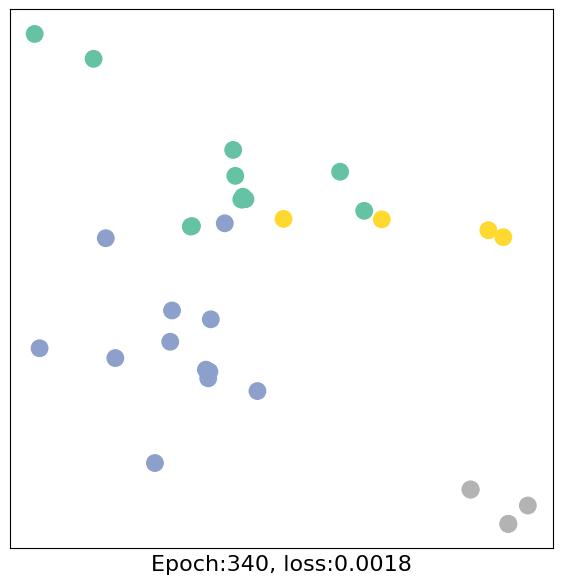

 85%|████████▌ | 341/401 [00:14<00:02, 23.56it/s]

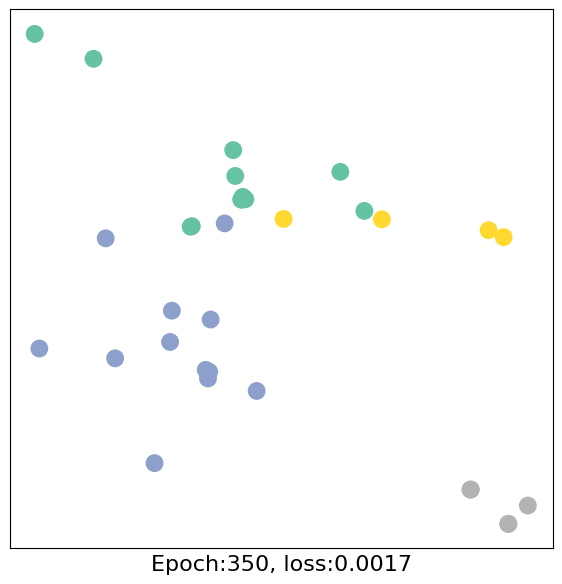

 88%|████████▊ | 351/401 [00:15<00:02, 23.54it/s]

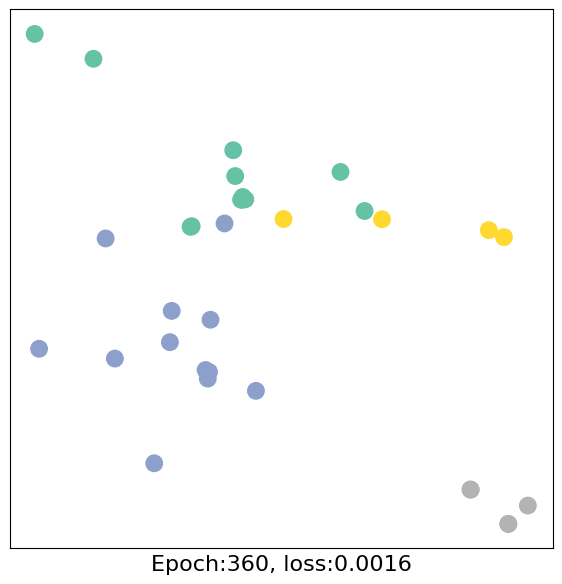

 90%|█████████ | 361/401 [00:15<00:01, 23.54it/s]

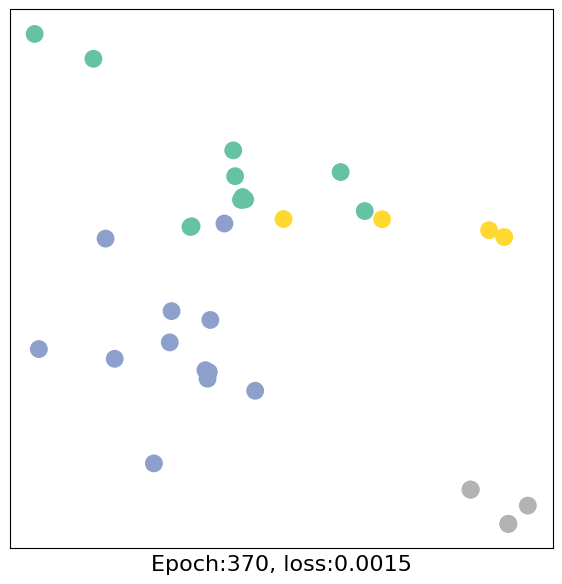

 93%|█████████▎| 371/401 [00:16<00:01, 23.58it/s]

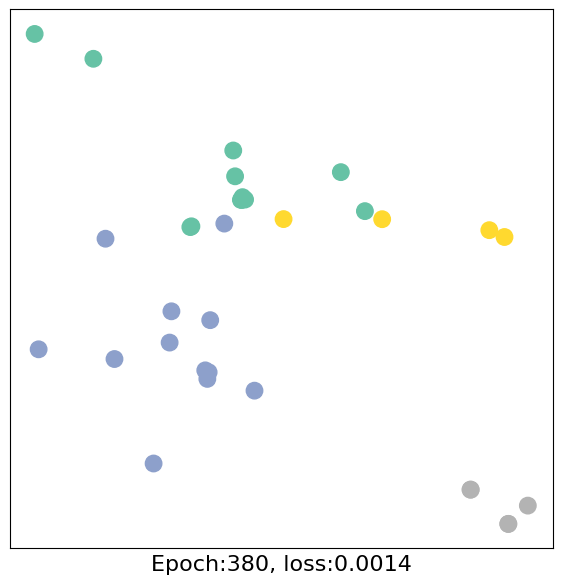

 95%|█████████▌| 381/401 [00:16<00:00, 23.59it/s]

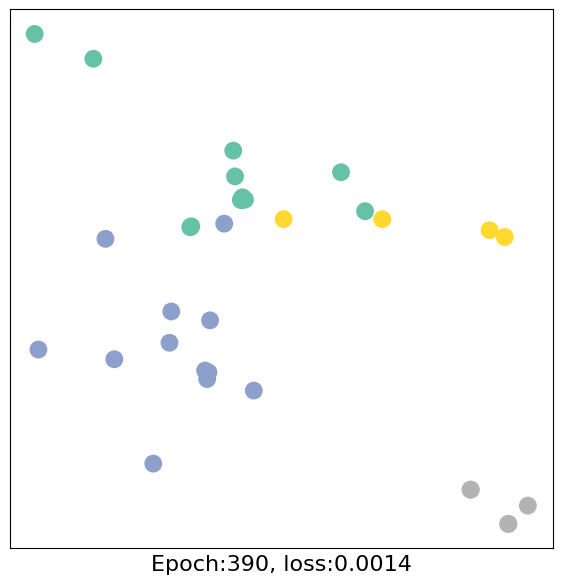

 98%|█████████▊| 391/401 [00:16<00:00, 23.63it/s]

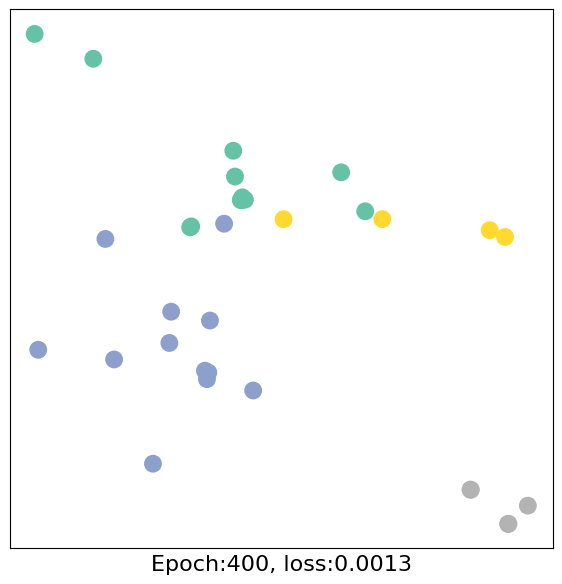

100%|██████████| 401/401 [00:17<00:00, 23.02it/s]


In [34]:
import time
from tqdm import *

model = GCN()
# 定义分类损失函数
criterion = torch.nn.CrossEntropyLoss()
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    # 梯度清零
    optimizer.zero_grad()
    # 前向传播
    out, h = model(data.x, data.edge_index)
    # 计算损失；输出只看有mask=true点的输出，标签只看有mask=ture的标签
    # 半监督学习
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    return loss, h

for epoch in tqdm(range(401)):
    loss, h = train(data)
    # 每10个epoch画一个图
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)